<a href="https://colab.research.google.com/github/SILVIAIRENE/Data-Scientist-Machine-Learning-Engineer-Introductory-Course/blob/master/Regresi%C3%B3n_log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

iter 0/3000 - loss: 0.693147 - val_loss: 0.608453
iter 300/3000 - loss: 0.137807 - val_loss: 0.209455
iter 600/3000 - loss: 0.126148 - val_loss: 0.189610
iter 900/3000 - loss: 0.122871 - val_loss: 0.182774
iter 1200/3000 - loss: 0.121592 - val_loss: 0.179422
iter 1500/3000 - loss: 0.121017 - val_loss: 0.177502
iter 1800/3000 - loss: 0.120736 - val_loss: 0.176300
iter 2100/3000 - loss: 0.120593 - val_loss: 0.175506
iter 2400/3000 - loss: 0.120517 - val_loss: 0.174961
iter 2700/3000 - loss: 0.120476 - val_loss: 0.174578

-- Métricas (Scratch Logistic) --
Accuracy:  0.8800
Precision: 0.8462
Recall:    0.9167
F1 score:  0.8800
Confusion matrix:
[[11  2]
 [ 1 11]]

-- Métricas (sklearn LogisticRegression) --
Accuracy:  0.9200
Precision: 0.9167
Recall:    0.9167
F1 score:  0.9167
Confusion matrix:
[[12  1]
 [ 1 11]]


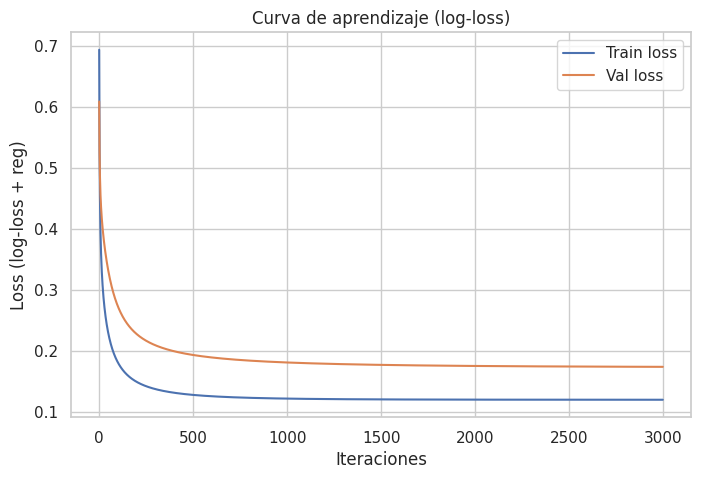

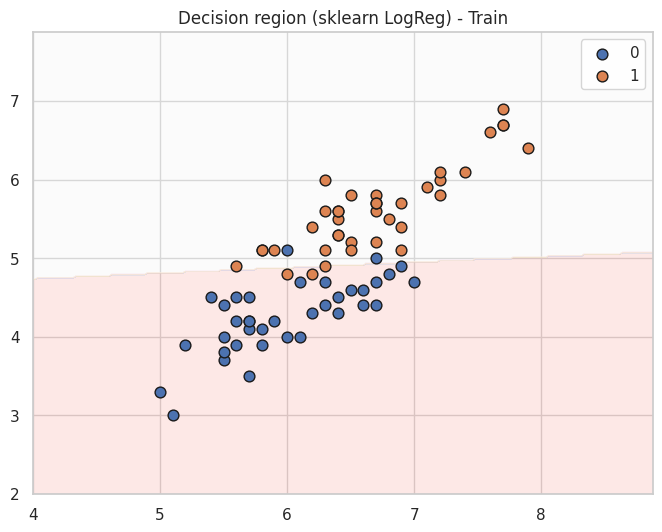

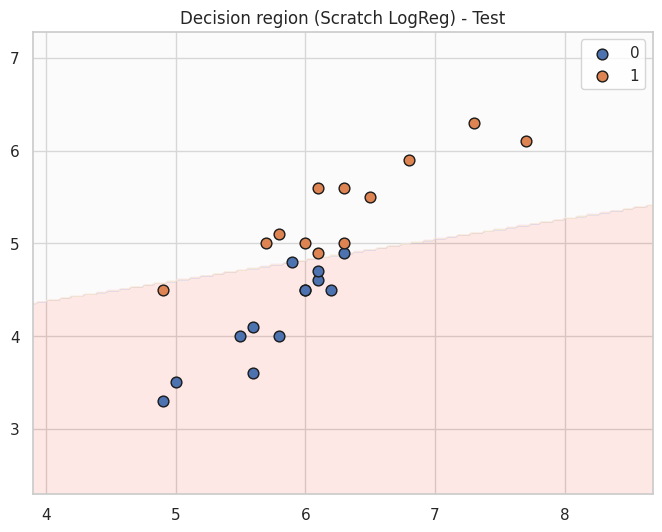

Guardado en: scratch_logreg_weights.npz y scratch_logreg_weights.pkl

-- Métricas (Scratch loaded weights) --
Accuracy:  0.8800
Precision: 0.8462
Recall:    0.9167
F1 score:  0.8800
Confusion matrix:
[[11  2]
 [ 1 11]]

Probabilidades ejemplo (primeros 6): [1.    0.931 0.312 0.034 0.999 1.   ]
Predicciones ejemplo (primeros 6): [1 1 0 0 1 1]

Listo. Cambia hyperparámetros (lr, num_iter, reg_lambda) para experimentar.


In [ ]:

# REGRESIÓN LOGÍSTICA - SCRATCH
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import pickle
import os

sns.set(style="whitegrid")


# Clase: ScratchLogisticRegression

class ScratchLogisticRegression:
    def __init__(self, num_iter=1000, lr=0.01, bias=True, verbose=False, reg_lambda=0.0):
        """
        num_iter: número de iteraciones
        lr: learning rate
        bias: True -> incluye término intercept (θ0)
        verbose: imprimir progreso
        reg_lambda: lambda de regularización (L2), >=0
        """
        self.iter = int(num_iter)
        self.lr = float(lr)
        self.bias = bool(bias)
        self.verbose = bool(verbose)
        self.reg_lambda = float(reg_lambda)
        # registros
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        self.coef_ = None  # vector de parámetros (incluye bias si bias=True)

    # sigmoide numericamente estable
    @staticmethod
    def _sigmoid(z):
        # z puede ser array
        # para estabilidad:
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    # funcion hipotética h_theta(X)
    def _linear_hypothesis(self, X):
        # X espera shape (n_samples, n_features) y self.coef_ shape (n_features,)
        return np.dot(X, self.coef_)

    # compute regularized log-loss J(θ)
    def _compute_loss(self, h, y):
        m = y.shape[0]
        eps = 1e-15
        h = np.clip(h, eps, 1 - eps)
        # log-loss (cross-entropy)
        loss = - (1.0 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        # regularización L2 (excluir bias / intercept)
        if self.reg_lambda > 0:
            if self.bias:
                theta_no_bias = self.coef_.copy()
                theta_no_bias[0] = 0.0
                reg_term = (self.reg_lambda / (2.0 * m)) * np.sum(theta_no_bias ** 2)
            else:
                reg_term = (self.reg_lambda / (2.0 * m)) * np.sum(self.coef_ ** 2)
            loss += reg_term
        return loss

    # gradiente descendente (actualiza self.coef_)
    def _gradient_descent(self, X, h, y):
        m = X.shape[0]
        # gradient base
        grad = (1.0 / m) * (X.T.dot(h - y))  # shape (n_features,)
        # regularización: añadir lambda/m * theta_j (pero no para bias)
        if self.reg_lambda > 0:
            if self.bias:
                theta_reg = self.coef_.copy()
                theta_reg[0] = 0.0  # no regularizar intercept
                grad += (self.reg_lambda / m) * theta_reg
            else:
                grad += (self.reg_lambda / m) * self.coef_
        # actualizar parámetros
        self.coef_ -= self.lr * grad

    # fit
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X: ndarray (n_samples, n_features)
        y: ndarray (n_samples,) con 0/1
        X_val, y_val: opcionales para registrar val_loss
        """
        # Validaciones mínimas de forma
        X = np.asarray(X)
        y = np.asarray(y).reshape(-1)

        if self.bias:
            # añadir columna de 1s
            X_train = np.hstack([np.ones((X.shape[0], 1)), X])
            if X_val is not None:
                X_val = np.asarray(X_val)
                X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
        else:
            X_train = X

        n_features = X_train.shape[1]
        # inicializar coeficientes en 0
        self.coef_ = np.zeros(n_features)

        # entrenamiento
        for i in range(self.iter):
            # forward
            z = self._linear_hypothesis(X_train)   # X_train dot coef
            h = self._sigmoid(z)                  # probabilidades

            # loss (train)
            self.loss[i] = self._compute_loss(h, y)

            # step gradiente descendente
            self._gradient_descent(X_train, h, y)

            # calcular val_loss si datos val se dieron
            if X_val is not None and y_val is not None:
                z_val = self._linear_hypothesis(X_val)
                h_val = self._sigmoid(z_val)
                self.val_loss[i] = self._compute_loss(h_val, y_val)

            if self.verbose and (i % max(1, self.iter // 10) == 0):
                s = f"iter {i}/{self.iter} - loss: {self.loss[i]:.6f}"
                if X_val is not None and y_val is not None:
                    s += f" - val_loss: {self.val_loss[i]:.6f}"
                print(s)

    # predict_proba: devuelve probabilidades (n_samples,)
    def predict_proba(self, X):
        X = np.asarray(X)
        if self.bias:
            Xp = np.hstack([np.ones((X.shape[0], 1)), X])
        else:
            Xp = X
        z = self._linear_hypothesis(Xp)
        return self._sigmoid(z)

    # predict: devuelve 0/1 con umbral 0.5
    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

    # guardar pesos con numpy savez y pickle
    def save_weights(self, path_prefix="logreg_weights"):
        # numpy savez
        npz_path = f"{path_prefix}.npz"
        np.savez(npz_path, coef=self.coef_, iter=self.iter, lr=self.lr, reg_lambda=self.reg_lambda, bias=self.bias)
        # pickle (clase estado mínimo)
        pkl_path = f"{path_prefix}.pkl"
        with open(pkl_path, "wb") as f:
            pickle.dump({"coef": self.coef_, "iter": self.iter, "lr": self.lr, "reg_lambda": self.reg_lambda, "bias": self.bias}, f)
        return npz_path, pkl_path

    # cargar pesos (reemplaza coef_ y otros parámetros si se encuentran)
    def load_weights(self, npz_path):
        data = np.load(npz_path)
        self.coef_ = data["coef"]
        # optionally restore other attrs
        try:
            self.iter = int(data["iter"])
            self.lr = float(data["lr"])
            self.reg_lambda = float(data["reg_lambda"])
            self.bias = bool(data["bias"])
        except Exception:
            pass

# Funciones auxiliares

def print_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

def decision_region_plot(X, y, model, scaler=None, title="Decision region", step=0.02, target_names=None):
    """
    X: (n_samples,2) - must be 2D features
    model: trained model with predict method that accepts raw X (not scaled) OR pass scaler to transform mesh
    scaler: scikit-learn scaler used on X (if any)
    """
    assert X.shape[1] == 2, "Decision region plot requires exactly 2 features."
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    mesh = np.c_[xx.ravel(), yy.ravel()]
    if scaler is not None:
        mesh_scaled = scaler.transform(mesh)
        Z = model.predict(mesh_scaled)
    else:
        Z = model.predict(mesh)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel1")
    # scatter
    for label in np.unique(y):
        plt.scatter(X[y == label, 0], X[y == label, 1], label=str(label), edgecolor='k', s=60)
    plt.legend()
    plt.title(title)
    plt.show()

# Demo con Iris dataset (versicolor vs virginica)

iris = datasets.load_iris()
X_all = iris.data
y_all = iris.target
# Use only classes 1 (versicolor) and 2 (virginica) -> binary; map to 0/1
mask = (y_all == 1) | (y_all == 2)
X = X_all[mask][:, [0, 2]]  # sepal length (0) and petal length (2)
y = y_all[mask]
# map 1->0, 2->1 (so labels are 0 and 1)
y = (y == 2).astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale features (important for gradient descent & comparision)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train scratch logistic

scratch = ScratchLogisticRegression(num_iter=3000, lr=0.5, bias=True, verbose=True, reg_lambda=0.01)
scratch.fit(X_train_scaled, y_train, X_val=X_test_scaled, y_val=y_test)

# Predictions and metrics
y_pred_scratch = scratch.predict(X_test_scaled)
print("\n-- Métricas (Scratch Logistic) --")
print_metrics(y_test, y_pred_scratch)


# Compare with sklearn LogisticRegression

sklog = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
sklog.fit(X_train_scaled, y_train)
y_pred_sk = sklog.predict(X_test_scaled)
print("\n-- Métricas (sklearn LogisticRegression) --")
print_metrics(y_test, y_pred_sk)


# Plot learning curves

plt.figure(figsize=(8,5))
plt.plot(np.arange(scratch.iter), scratch.loss, label="Train loss")
if np.any(scratch.val_loss):
    plt.plot(np.arange(scratch.iter), scratch.val_loss, label="Val loss")
plt.xlabel("Iteraciones")
plt.ylabel("Loss (log-loss + reg)")
plt.title("Curva de aprendizaje (log-loss)")
plt.legend()
plt.show()


# Decision region (usar X_train_scaled de 2 features)

decision_region_plot(X_train, y_train, model=sklog, scaler=scaler, title="Decision region (sklearn LogReg) - Train")
decision_region_plot(X_test, y_test, model=scratch, scaler=scaler, title="Decision region (Scratch LogReg) - Test")


# Guardar / cargar pesos

npz_path, pkl_path = scratch.save_weights("scratch_logreg_weights")
print(f"Guardado en: {npz_path} y {pkl_path}")

# Load with a fresh instance to verify
scratch_loaded = ScratchLogisticRegression(num_iter=1, lr=0.1, bias=True)
scratch_loaded.load_weights(npz_path)
# same predictions?
y_pred_loaded = scratch_loaded.predict(X_test_scaled)
print("\n-- Métricas (Scratch loaded weights) --")
print_metrics(y_test, y_pred_loaded)

# Ejemplos finales: probabilidades
probs = scratch.predict_proba(X_test_scaled)[:6]
print("\nProbabilidades ejemplo (primeros 6):", np.round(probs, 3))
print("Predicciones ejemplo (primeros 6):", scratch.predict(X_test_scaled)[:6])
# Nota final

print("\nListo. Cambia hyperparámetros (lr, num_iter, reg_lambda) para experimentar.")
